# About problem

The project goal is to predict change of the temperature of Earth surface based on emission of co2. Model could be used to predict the temperature of Earth surface based on the emission of annual co2 emission.

Data used in the project come from 2 sources:
- CO₂ and Greenhouse Gas Emissions
by Hannah Ritchie, Max Roser and Pablo Rosado
[Link to data](https://ourworldindata.org/co2-and-greenhouse-gas-emissions)
- Climate Change: Earth Surface Temperature Data
[Link to data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?resource=download&select=GlobalLandTemperaturesByCity.csv)

Data contain:
- annual temperature of earth surface and from years 1850 to 2015
- annual emmision of CO2 on earth from years 1850 to 2015
- temperature change from CO2 emmision from first obserwations


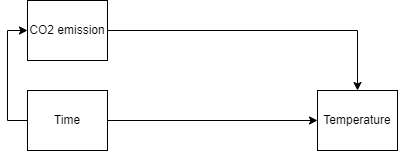

In [1]:
from IPython.display import Image
Image(filename="/home/DAG.png")

Temperature is defined by two factors co2 emission and time. As time I asume changes of value as time passes. There are one collider from CO2 emission and time into temperature and one pipe Time->CO2 emission->Temperature

In [2]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preprocessing

In [3]:
df = pd.read_csv('/home/owid-co2-data.csv')
df_k = df.loc[df['country'] == 'World'][['year', 'country', 'temperature_change_from_co2', 'co2']]

df_k = df_k.loc[~df_k['temperature_change_from_co2'].isna()]

df = pd.read_csv('/home/GlobalTemperatures.csv')
df_k = df_k.loc[df_k['year'] < 2016]
years = df_k['year'].unique()

mask = (df['dt'] > '1850-12-01') & (df['dt'] <= '2022-01-01')
df2 = df.loc[mask]
avg_temp = []
for year in years:
    avg_temp.append(df2.loc[((df2['dt'] >= (str(year) + '-01-01')) & (df2['dt'] < (str(year + 1) + '-01-01')))]['LandAverageTemperature'].sum()/12)

df_k.insert(4, "Yearly_avg_temp", avg_temp, True)
    

In [4]:
df_k

,year,country,temperature_change_from_co2,co2,Yearly_avg_temp
49911,1851,World,0.001,198.805,8.178583
49912,1852,World,0.002,207.551,8.100167
49913,1853,World,0.004,217.209,8.041833
49914,1854,World,0.005,255.139,8.210500
49915,1855,World,0.006,260.166,8.110750
...,...,...,...,...,...
50071,2011,World,0.930,34487.012,9.516000
50072,2012,World,0.948,35006.270,9.507333
50073,2013,World,0.966,35319.203,9.606500
50074,2014,World,0.985,35577.535,9.570667


The data was read from csv files and filtered from rows containing Nan values. The necessary data has been written to the table which can be seen above and this table is used in next steps of project. When I was preprocessing data I got rid of rows with Nan values, beacouse it's will only make bugs and errors. I narrowed the number of anylyzed years to these that contain all data required to create models, also I picked only values that are presented for entire world, beacouse I anylze global temperatures.

# Model specification
In this project I created 2 models using library for python that let me create models in stan language

## First model specification

The model use normal distribution to pick parameter alpha, which is equal to temperature of earth surface if there where no increase of co2 emission. Gamma distribution was used to pick parameter beta, which specify how temperature increase depends on emission of co2. I decided to use gamma distribution, beacouse it can contain only positive values, which was the behavior I wanted for parameter beta, beacosue when I analyzed data it I found out that increase of co2 can only make temperature go up. I use linear regresion to model the dependency of temperature from co2 emission, which is passed to mu parameter in normal distribution. For model creation we require data about annual co2 production and annual temperature of surface.

In [5]:
%%writefile model_1.stan

data {
  int N;
  vector[N] co2_production;
  real prior_mu_alpha;
  real prior_sigma_alpha;
  real prior_mu_beta;
  real prior_sigma_beta;
  real ypred[N];
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters {
    vector[N] mu = co2_production*beta+alpha;
}

model {
    alpha ~ normal(prior_mu_alpha, prior_sigma_alpha);
    beta ~ gamma(prior_mu_beta, prior_sigma_beta);
    sigma ~ exponential(0.067);
    ypred ~ normal(mu, sigma);
}

generated quantities {
  real temp[N];
  vector[N] log_lik;
  for (i in 1:N){
    log_lik[i] = normal_lpdf(ypred[i]|mu[i], sigma);
    temp[i] = normal_rng(mu[i], sigma);
  }
}

Overwriting model_1.stan


## Second model specification
The second model is mostly like first model, but I decided to use student distribution to pick parameter alpha. The reasoning behind that is that some values of temperature for low values of co2 production and temperatures without impact of co2 production had wide spread values of temperature. For this case student distribution should work better.

In [47]:
%%writefile model_2.stan

data {
  int N;
  vector[N] co2_production;
  real prior_mu_alpha;
  real prior_sigma_alpha;
  real prior_mu_beta;
  real prior_sigma_beta;
  real ypred[N];
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
    real<lower=1, upper=80> nu;
}

transformed parameters {
    vector[N] mu = co2_production*beta+alpha;
}

model {
    alpha ~ student_t(nu, prior_mu_alpha, prior_sigma_alpha);
    beta ~ gamma(prior_mu_beta, prior_sigma_beta);
    sigma ~ exponential(0.067);
    nu ~ gamma(2, 0.4);
    ypred ~ normal(mu, sigma);
}

generated quantities {
  vector[N] log_lik;
  real temp[N];
  for (i in 1:N){
    log_lik[i] = normal_lpdf(ypred[i]|mu[i],sigma);
    temp[i] = normal_rng(mu[i], sigma);
  }
}

Overwriting model_2.stan


# Priors

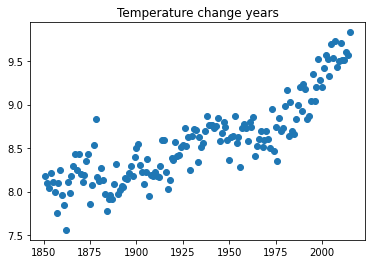

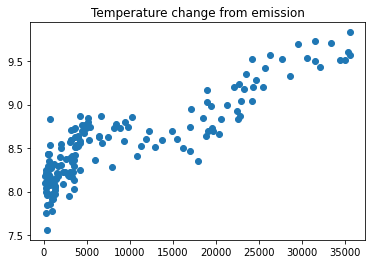

In [7]:
plt.scatter(df_k['year'], df_k['Yearly_avg_temp'])
plt.title('Temperature change years')
plt.show()

plt.scatter(df_k['co2'], df_k['Yearly_avg_temp'])
plt.title('Temperature change from emission')
plt.show()

Above plot show relation of temperature to CO2 emmision, we can see that increase of emmision make temperature go up.

Mean value: 8.285388383838384
Std value: 0.25323409979916156


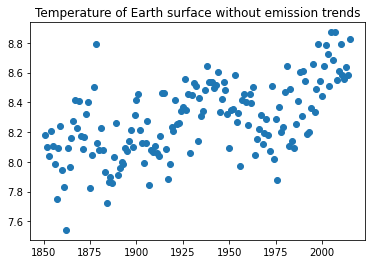

In [8]:
temp_without_co2 = df_k['Yearly_avg_temp'] - df_k['temperature_change_from_co2']
plt.scatter(df_k['year'], temp_without_co2)
plt.title('Temperature of Earth surface without emission trends')
temp_mean = np.mean(temp_without_co2)
temp_std = np.std(temp_without_co2)
print(f'Mean value: {temp_mean}')
print(f'Std value: {temp_std}')

I decided to use information about temperature change from emission of CO2 to substract it from temperature and extract mean and std of temperature to use it, as my priors to calculate alpha value. As for parameter beta I determined priors by trial and error method. I picked parameters for it and looked if results make sense.

In [9]:
temp_mean = np.mean(df_k['Yearly_avg_temp'])
temp_std = np.std(df_k['Yearly_avg_temp'])

In [10]:
%%writefile model_1_priors.stan

data {
  int N;
  real co2_production[N];
  real prior_mu_alpha;
  real prior_sigma_alpha;
  real prior_mu_beta;
  real prior_sigma_beta;
}

generated quantities {
  real alpha = normal_rng(prior_mu_alpha, prior_sigma_alpha);
  real beta = gamma_rng(prior_mu_beta, prior_sigma_beta);
  real sigma = exponential_rng(0.067);
  real ypred[N];
  for (i in 1:N){
    ypred[i] = normal_rng(alpha + beta*co2_production[N], sigma);
  }
}

Overwriting model_1_priors.stan


In [11]:
fit_model = CmdStanModel(stan_file='model_1_priors.stan')
data_fit = dict(prior_mu_alpha = temp_mean, prior_sigma_alpha = temp_std, prior_mu_beta = 1.2, prior_sigma_beta = 6, N=len(df_k), co2_production=df_k['co2']/10000)
fit = fit_model.sample(data=data_fit, seed=15042023, fixed_param=True, iter_sampling=len(df_k))

INFO:cmdstanpy:compiling stan file /model_1_priors.stan to exe file /model_1_priors
INFO:cmdstanpy:compiled model executable: /model_1_priors
--- Translating Stan model to C++ code ---
bin/stanc  --o=/model_1_priors.hpp /model_1_priors.stan
Warning in '/model_1_priors.stan', line 4, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc
Warning in '/model_1_priors.stan', line 15, column 2: Declaration of arrays
    by placing brackets after a variable name is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include 


INFO:cmdstanpy:CmdStan done processing.


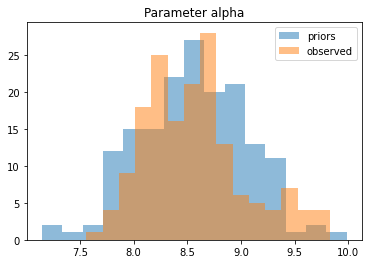

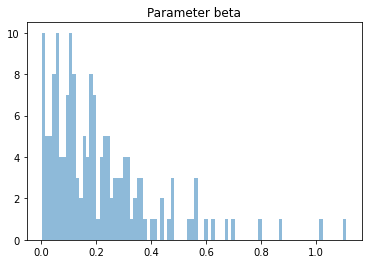

Text(0.5, 1.0, 'Predictions of temperature to co2 production')

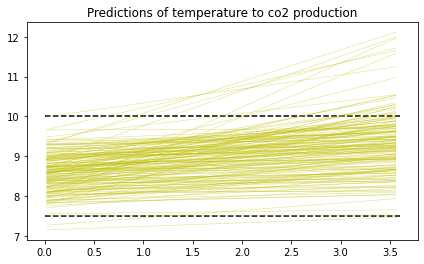

In [37]:
alpha = fit.draws_pd()['alpha']

plt.hist(alpha, bins=15, alpha=0.5, label='priors')
plt.hist(df_k['Yearly_avg_temp'], bins=15, alpha=0.5, label='observed')
plt.legend()
plt.title('Parameter alpha')
plt.show()

beta = fit.draws_pd()['beta']
plt.hist(beta, bins=90, alpha=0.5)
plt.title('Parameter beta')
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([7.5, 10], xmin=0, xmax=3.6, linestyle='--', color='black')
for i in range(len(df_k)-1):
    axes.plot(df_k['co2']/10000, alpha[i]+beta[i]*df_k['co2']/10000, color='y', alpha=0.5, linewidth=0.5)
plt.title('Predictions of temperature to co2 production')

The distribution of parametref alpha it mostly match the distribution of temperature withour emission trend, which can be seen on first plot. Parameter beta is set with low values to don't overmeasure how much it depend on temperature change, which can be seen on second plot. Priors for parameters make sense. As for the third plot which show the regresion lines for change of temperature based on emission of CO2. Most of regresion lines fit between max and lowest value of Earth surface temperature measuret. Most of them make sense, which is enough to procced to posterior analyzys.

# Posterior analyzys model 1

In [38]:
fit_model = CmdStanModel(stan_file='model_1.stan')
data_fit = dict(prior_mu_alpha = temp_mean, prior_sigma_alpha = temp_std, prior_mu_beta = 1.2, prior_sigma_beta = 6, N=len(df_k), co2_production=df_k['co2']/10000, ypred=df_k['Yearly_avg_temp'])
fit2 = fit_model.sample(data=data_fit, seed=15042023)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [39]:
print(fit2.diagnose())

Processing csv files: /tmp/tmp4mctjpbl/model_1-20230712130835_1.csv, /tmp/tmp4mctjpbl/model_1-20230712130835_2.csv, /tmp/tmp4mctjpbl/model_1-20230712130835_3.csv, /tmp/tmp4mctjpbl/model_1-20230712130835_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



There where no problems with sampling.

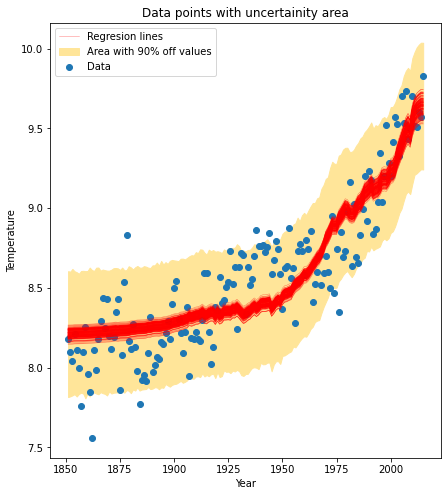

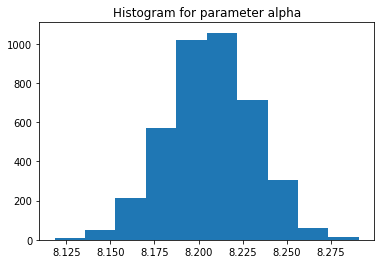

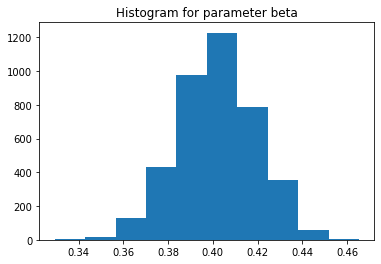

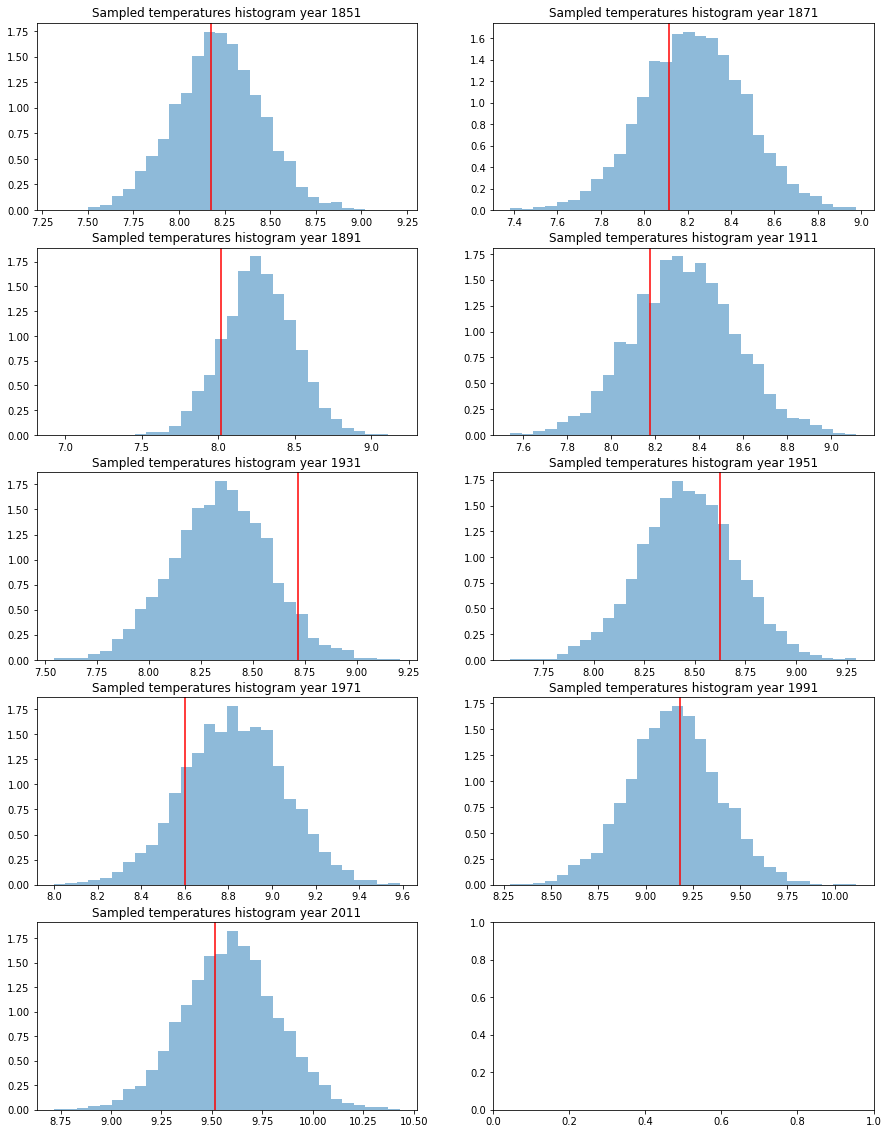

In [66]:
vals = fit2.draws_pd()
fig, axes = plt.subplots(1,1, figsize=(7, 8), sharey=True, sharex=True)
mu = vals.iloc[:, 175:340].values

ax0 = axes
ax0.plot(df_k['year'], vals['alpha'].values[0] + vals['beta'].values[0] * df_k['co2']/10000, color='#FF0000', linewidth=0.5, alpha=0.5, label='Regresion lines')
for i in range(len(df_k)-1):
    ax0.plot(df_k['year'], vals['alpha'].values[i] + vals['beta'].values[i] * df_k['co2']/10000, color='#FF0000', linewidth=0.5, alpha=0.5)

ax0.fill_between(df_k['year'], np.percentile(mu, 5, axis=0), np.percentile(mu, 95, axis=0), color='#FFE599', label='Area with 90% off values')
ax0.scatter(df_k['year'], df_k['Yearly_avg_temp'], label='Data')
plt.title('Data points with uncertainity area')
ax0.set_xlabel('Year')
ax0.set_ylabel('Temperature')
plt.legend()
plt.show()
plt.hist(vals['alpha'].values)
plt.title('Histogram for parameter alpha')
plt.show()
plt.hist(vals['beta'].values)
plt.title('Histogram for parameter beta')
plt.show()

fig, ax = plt.subplots(5,2, figsize=(15,20))
ax = ax.reshape(-1)
for i in range(len(mu[0, :])):
    if i % 20 == 0:
        ax[int(i/20)].set_title(f'Sampled temperatures histogram year {df_k["year"].iloc[i]}')
        ax[int(i/20)].hist(mu[:, i], bins=30, density=True, alpha=0.5)
        ax[int(i/20)].axvline(x=df_k['Yearly_avg_temp'].iloc[i], color='red')
plt.show()

Model fits most of the data. For lower values of emission there are some samples, which are outside of the orange area for early years which could be error in measurements or at that time the variations between high and low temperature where mostly caused by natural changes of earth temperature which are described by parameter alpha. 

For parameters alpha and beta. Alpha parameter mean value was set a little lower than in prios and values are more concetrated around mean value. The values for parameter alpha are looking good, because of low standard deviation and mean value is close to priors which where determined from data.

Paremeter beta was changed drastrictly compared to priors. The shape of it distribution is like normla distribution, so it could be good idea to use normal distibution to sample this parameter. Values are concetrated around mean value which is really good. We can say that influence of co2 emission is quite high in temperature change.

# Posterior analysis model 2

In [49]:
fit_model = CmdStanModel(stan_file='model_2.stan')
data_fit = dict(prior_mu_alpha = temp_mean, prior_sigma_alpha = temp_std, prior_mu_beta = 1.2, prior_sigma_beta = 6, N=len(df_k), co2_production=df_k['co2']/10000, ypred=df_k['Yearly_avg_temp'])
fit3 = fit_model.sample(data=data_fit, seed=15042023)

INFO:cmdstanpy:compiling stan file /model_2.stan to exe file /model_2
INFO:cmdstanpy:compiled model executable: /model_2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/model_2.hpp /model_2.stan
Warning in '/model_2.stan', line 9, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc
Warning in '/model_2.stan', line 33, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/


INFO:cmdstanpy:CmdStan done processing.


In [50]:
print(fit3.diagnose())

Processing csv files: /tmp/tmp4mctjpbl/model_2-20230712131244_1.csv, /tmp/tmp4mctjpbl/model_2-20230712131244_2.csv, /tmp/tmp4mctjpbl/model_2-20230712131244_3.csv, /tmp/tmp4mctjpbl/model_2-20230712131244_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



There where no problems with sampling.

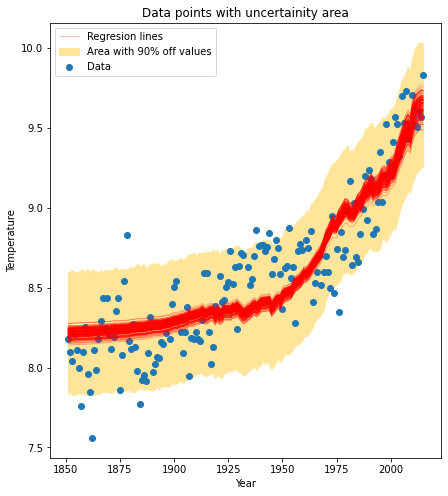

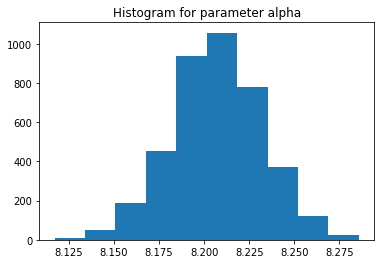

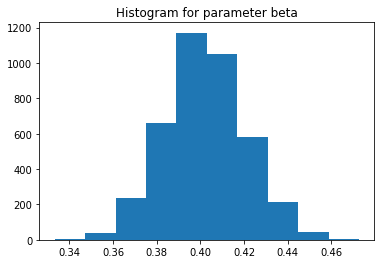

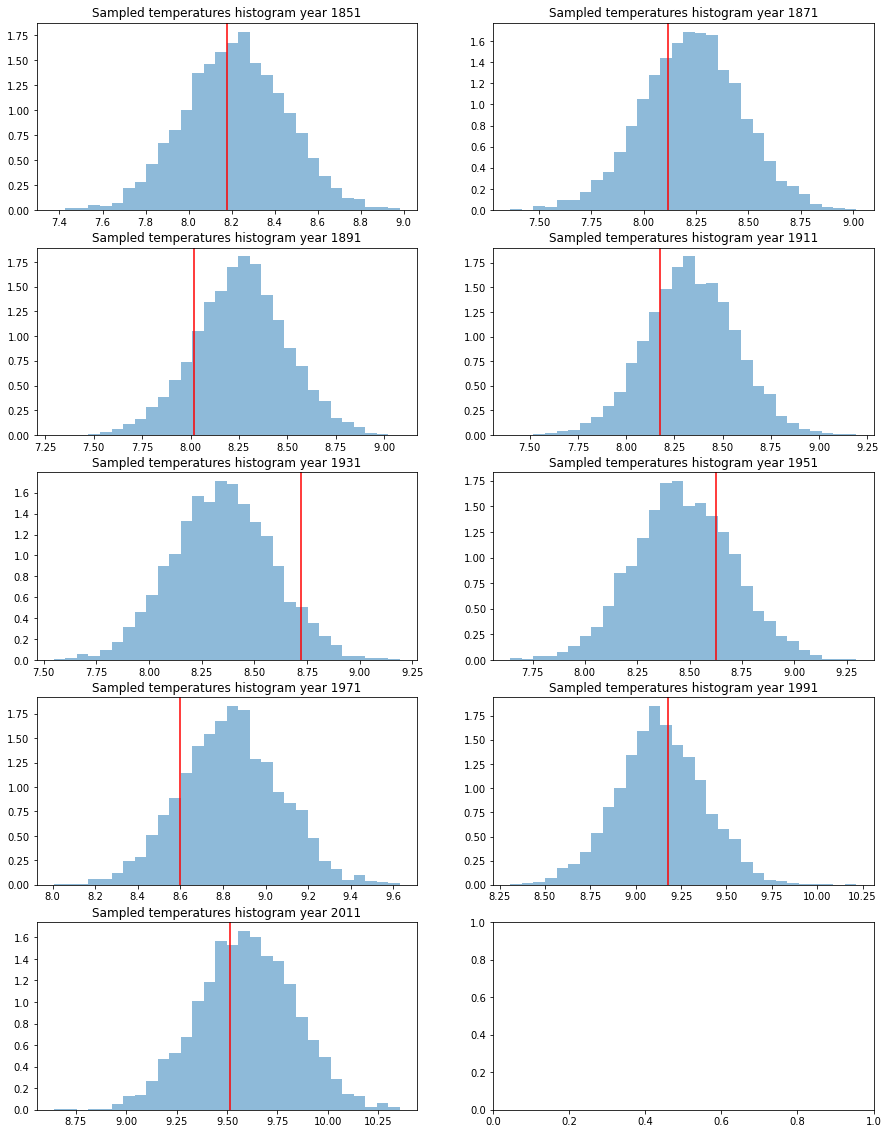

In [67]:
vals = fit3.draws_pd()
fig, axes = plt.subplots(1,1, figsize=(7, 8), sharey=True, sharex=True)
mu = vals.iloc[:, 341:].values

ax0 = axes
ax0.plot(df_k['year'], vals['alpha'].values[0] + vals['beta'].values[0]*df_k['co2']/10000, color='#FF0000', linewidth=0.5, alpha=0.5, label='Regresion lines')
for i in range(len(df_k)-1):
    ax0.plot(df_k['year'], vals['alpha'].values[i] + vals['beta'].values[i]*df_k['co2']/10000, color='#FF0000', linewidth=0.5, alpha=0.5)
ax0.fill_between(df_k['year'], np.percentile(mu, 5, axis=0), np.percentile(mu, 95, axis=0), color='#FFE599', label='Area with 90% off values')
ax0.scatter(df_k['year'], df_k['Yearly_avg_temp'], label='Data')
plt.title('Data points with uncertainity area')
ax0.set_xlabel('Year')
ax0.set_ylabel('Temperature')
plt.legend()
plt.show()
plt.hist(vals['alpha'].values)
plt.title('Histogram for parameter alpha')
plt.show()
plt.hist(vals['beta'].values)
plt.title('Histogram for parameter beta')
plt.show()

fig, ax = plt.subplots(5,2, figsize=(15,20))
ax = ax.reshape(-1)
for i in range(len(mu[0, :])):
    if i % 20 == 0:
        ax[int(i/20)].set_title(f'Sampled temperatures histogram year {df_k["year"].iloc[i]}')
        ax[int(i/20)].hist(mu[:, i], bins=30, density=True, alpha=0.5)
        ax[int(i/20)].axvline(x=df_k['Yearly_avg_temp'].iloc[i], color='red')
plt.show()

Model fits most of the data. The use of the student's distribution allowed the data for the early years to be within 90% of the data predictions as expected. The data for newer years is mostly unchanged and fit measures, but now it have wider range for data and it's not really precise in this part of plot. Best idea would be probably to extend amount of predictors and don't change type of distribution for parameter alpha, cuz for early ages temperature changes are probably mostly determined by natural predictors, which are not considered here. They are boundled inside parameter alpha.

For parameters alpha and beta. Alpha parameter mean value was set a little lower than in prios and values are more concetrated around mean value. The values for parameter alpha are looking good, because of low standard deviation and mean value is close to priors which where determined from data.

Paremeter beta was changed drastrictly compared to priors. Values are concetrated around mean value which is really good. We can say that influence of co2 emission is quite high in temperature change.

# Model comparison

In [52]:
model1 = az.from_cmdstanpy(fit2)
model2 = az.from_cmdstanpy(fit3)
model1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [53]:
model2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [54]:
models = {"model1": fit2, "model2": fit3}

## WAIC results
WAIC is measure of model fit that compare balance between goodness of models and model complexity. For this indicator model1 was considered better, which was expected, because adding more complexity to second model didn't really change a lot. Higher weight for first model indicate that it is better at extracting information from data.

Calculated values for WAIC, are most likely reliable, beacouse there where no errors during calculations.

In [55]:
comparison = az.compare(models, ic="waic", scale="deviance")
comparison

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model1,0,-11.237741,2.500619,0.00000,1.0,16.317811,0.000000,False,deviance
model2,1,-11.051751,2.585580,0.18599,0.0,16.368627,0.054781,False,deviance


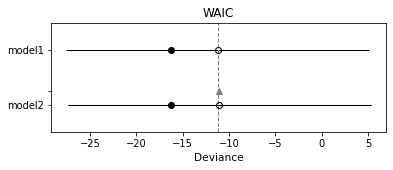

In [56]:
az.plot_compare(comparison)
plt.title('WAIC')
plt.show()

## LOO results
LOO is indicator that is based on predictive accuracy of the model. For this indicator model1 was considered better, which isn't great information, because I wanted second model to be better. Extending ranges for parameter alpha to include distant measures was bad idea, beacouse as we can see it reduced model predictive accurasy, which I should have predicted from analyzing plot for distribution of values and data points. From indicators I can also say that weight of model1 is really high which determine that it's best.

Calculated values for LOO, are most likely reliable, beacouse there where no errors during calculations.

In [57]:
comparison = az.compare(models, ic="loo", scale="deviance")
comparison

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model1,0,-11.238197,2.500391,0.000000,1.0,16.317323,0.000000,False,deviance
model2,1,-11.048735,2.587088,0.189462,0.0,16.369404,0.056173,False,deviance


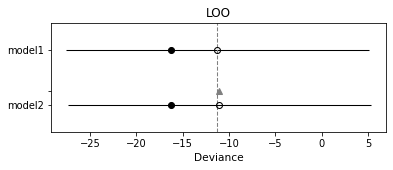

In [58]:
az.plot_compare(comparison)
plt.title('LOO')
plt.show()

## Finall model comparison
First model is superior to second in every aspect compared above. The only thig it does better is predicting values for low emission of co2, but for every other case it's performe worse and is less effective. Indicators of LOO and WAIC can be trusted, because there where no errors and after anylyzing models I can come to the same conclusions as these indicators.

As for what can be done to improve model. I think that adding some predictors which are not based on emission, but some natural factors like rinfall or other changes which can cause temperature to be lower on higher in year.